# 03.3 Time-Series Prediction for brent oil price from 1987 to 2020
#### 賴昱瑋 YUWEI LAI, 2020
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## (a) Dataset description
Use the brent oil weekly price from 1987 to 2020 with 1750 observations. (From https://fred.stlouisfed.org/categories/32217)

In [3]:
brentoil0 = pd.read_csv(r'/03.3_WCOILBRENTEU.csv')
brentoil0.head()

,DATE,WCOILBRENTEU
0,1987-05-15,18.58
1,1987-05-22,18.54
2,1987-05-29,18.60
3,1987-06-05,18.70
4,1987-06-12,18.75


In [4]:
brentoil = brentoil0.iloc[:, 1:2]
brentoil.describe()

,WCOILBRENTEU
count,1750.000000
mean,46.404000
std,32.367572
min,9.440000
25%,18.802500
50%,32.770000
75%,66.575000
max,141.070000


---
## (b) LSTM model
### Dataset format

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
brentoil_scaled = sc.fit_transform(brentoil)

In [6]:
x, y = [], []
past_week = 5
ahead_week = 1
for i in range(brentoil_scaled.shape[0] - past_week): # Use past 5 weeks dataset for 5-week ahead prediction
  x.append(np.array(brentoil_scaled[i:i + past_week]))
  y.append(np.array(brentoil_scaled[i + past_week:i + past_week + 1]))

x = np.array(x)
y = np.array(y)

In [7]:
# Seperate the dataset into a training set and a testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) # Total 0.2 as testing
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.125) # Total 0.1 as validation

y_train = np.array(y_train, dtype = float)
y_validation = np.array(y_validation, dtype = float)
y_test = np.array(y_test, dtype = float)

# x should be reshape to 3-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_validation = np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1], 1))

### Model building

In [8]:
model = keras.models.Sequential([
     keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)),
     keras.layers.Dense(units = 1)
    ])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dense (Dense)                (None, 5, 1)              51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
callback = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10, verbose = 1, mode = "auto")
model.fit(x_train, y_train, epochs = 500, batch_size = 128, validation_data = (x_validation, y_validation), callbacks=[callback])

Epoch 1/500
10/10 [==============================] - 0s 48ms/step - loss: 0.1118 - val_loss: 0.0746
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0635 - val_loss: 0.0417
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0401 - val_loss: 0.0354
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0368 - val_loss: 0.0314
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0318 - val_loss: 0.0275
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0247
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.0219
Epoch 8/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0226 - val_loss: 0.0193
Epoch 9/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0198 - val_loss: 0.0169
Epoch 10/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0147
Epoch 11

In [10]:
predict_results = []
expect_results = []

flatten = lambda lst: [item for sub in lst for item in sub]

expect_results.extend(flatten(y_test.tolist()))
predict_results.extend(model.predict(x_test))
for i in range(len(predict_results)):
  predict_results[i] = min(predict_results[i].tolist())

print(flatten(sc.inverse_transform(expect_results)),'\n', flatten(sc.inverse_transform(predict_results)))

[51.46, 17.42, 43.16, 20.2, 20.93, 40.89, 17.15, 58.58, 23.2, 36.51, 63.76, 111.78, 28.399999999999995, 18.41, 75.29, 66.56, 55.54, 19.88, 109.08, 23.57, 12.26, 105.39, 16.72, 17.95, 61.06, 36.28, 51.48, 52.08, 14.55, 48.99, 24.89, 107.68, 73.95, 33.95, 114.53, 18.11, 9.85, 21.66, 27.329999999999995, 126.61999999999999, 43.63, 97.21, 16.11, 31.579999999999995, 107.83, 63.63000000000001, 39.41, 110.72, 63.49, 27.189999999999998, 18.11, 14.92, 116.67, 99.1, 110.42, 17.74, 14.64, 46.49, 77.62, 47.51, 76.68, 32.00999999999999, 16.8, 17.98, 35.71, 50.7, 17.14, 20.16, 43.29, 16.75, 25.19, 16.08, 101.94, 17.94, 73.39, 90.42, 25.74, 14.49, 114.53, 39.98, 72.17, 17.27, 71.25, 15.72, 19.83, 18.73, 16.88, 71.33, 69.54, 14.130000000000003, 74.09, 74.94, 60.36, 13.64, 100.36, 27.28, 19.41, 16.79, 54.14, 108.27, 135.54, 28.169999999999998, 28.179999999999996, 15.76, 111.12, 14.18, 19.24, 25.35, 57.17, 17.2, 14.61, 31.7, 48.95, 14.0, 85.23, 20.21, 21.11, 10.58, 28.449999999999996, 99.88, 16.9, 61.52,

---
## (c) Visualization

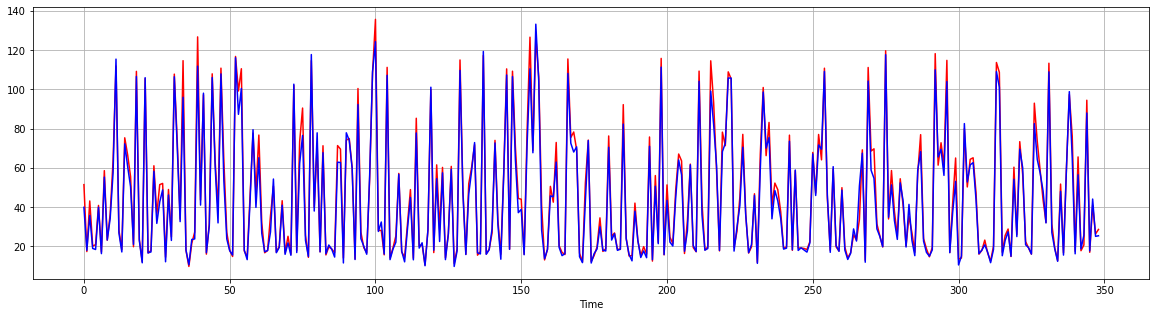

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.plot(flatten(sc.inverse_transform(expect_results)), color = 'red', label = '')
plt.plot(flatten(sc.inverse_transform(predict_results)), color = 'blue', label = '')
plt.grid(True)
plt.title('')
plt.xlabel('Time')
plt.ylabel('')
plt.show()

In [13]:
x_reshape = np.reshape(x, (x.shape[0], x.shape[1], 1))
pre_all_x = []
pre_all_x.extend(model.predict(x_reshape))

for i in range(len(pre_all_x)):
  pre_all_x[i] = flatten(sc.inverse_transform(pre_all_x[i]))

sc.inverse_transform(model.predict(bind))

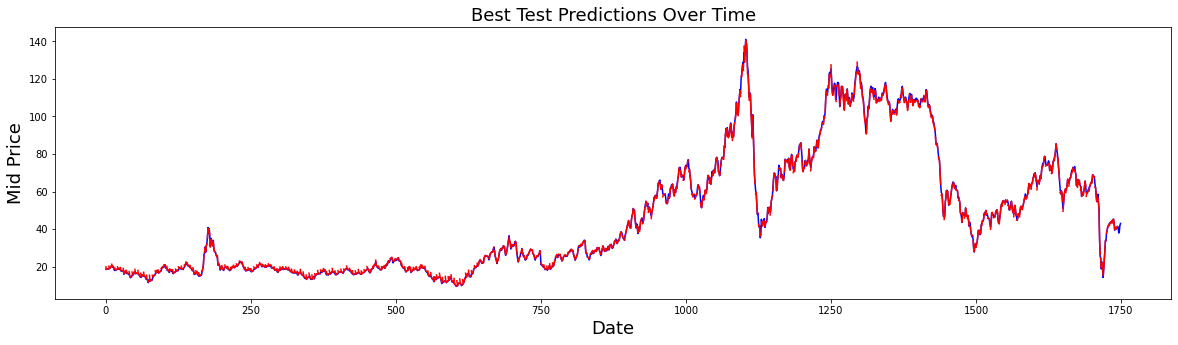

In [14]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(brentoil.shape[0]), brentoil ,color='b')

x_val = 0
for i in range(0, len(pre_all_x), past_week):
  plt.plot([k for k in range(x_val, x_val + past_week)], pre_all_x[i], color='r')
  x_val += past_week

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()